In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [ ]:
dataset='../input/vegetable-image-dataset/Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(test_folder))

There are 200 files in Broccoli
There are 200 files in Capsicum
There are 200 files in Bottle_Gourd
There are 200 files in Radish
There are 200 files in Tomato
There are 200 files in Brinjal
There are 200 files in Pumpkin
There are 200 files in Carrot
There are 200 files in Papaya
There are 200 files in Cabbage
There are 200 files in Bitter_Gourd
There are 200 files in Cauliflower
There are 200 files in Bean
There are 200 files in Cucumber
There are 200 files in Potato


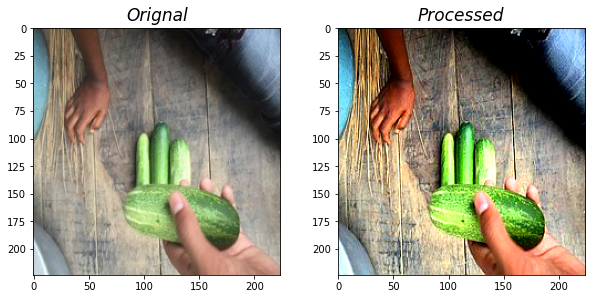

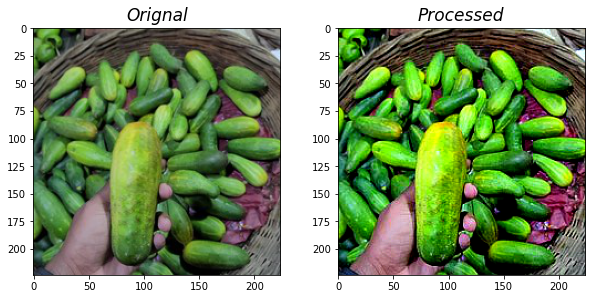

In [ ]:
# Specify the folder containing the images of the desired vegetable
image_folder = "Cucumber"

# Specify the number of images to display
number_of_images = 2

# Function to preprocess and display images
def Preprocess():
    # Counter variable for subplot indexing
    j = 1

    # Loop through the specified number of images
    for i in range(number_of_images):

        # Create the path to the image folder
        folder = os.path.join(test_folder, image_folder)

        # Choose a random image from the folder
        a = random.choice(os.listdir(folder))

        # Open the selected image
        image = Image.open(os.path.join(folder, a))

        # Create a duplicate of the original image for processing
        image_duplicate = image.copy()

        # Set up the matplotlib figure for displaying the images
        plt.figure(figsize=(10, 10))

        # Display the original image in the subplot
        plt.subplot(number_of_images, 2, j)
        plt.title(label='Original', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j += 1

        # Enhance the color, contrast, and sharpness of the duplicate image
        image1 = ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1 = ImageEnhance.Contrast(image1).enhance(1.45)
        image1 = ImageEnhance.Sharpness(image1).enhance(2.5)

        # Display the processed image in the subplot
        plt.subplot(number_of_images, 2, j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j += 1

# Call the Preprocess function to execute the image processing and display
Preprocess()


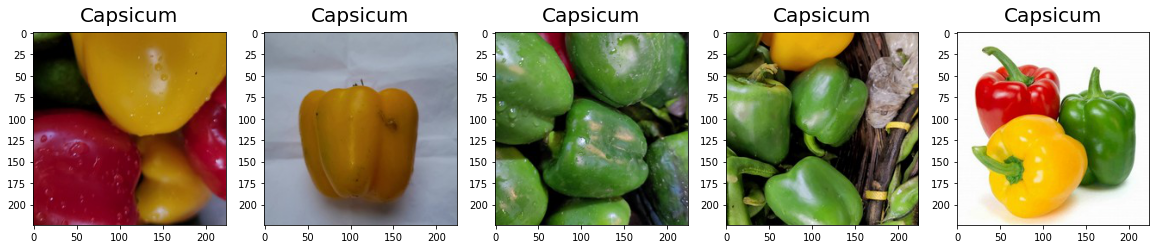

In [ ]:
# Specify the vegetable to be displayed
select_vegetable = "Capsicum"

# Specify the number of rows and columns for the display grid
rows, columns = 1, 5

# Create the path to the folder containing images of the selected vegetable
display_folder = os.path.join(train_folder, select_vegetable)

# Calculate the total number of images to be displayed
total_images = rows * columns

# Create a figure for displaying images with specified size
fig = plt.figure(1, figsize=(20, 10))

# Loop through the images in the display folder
for i, j in enumerate(os.listdir(display_folder)):

    # Read the image
    img = plt.imread(os.path.join(train_folder, select_vegetable, j))

    # Create subplots within the specified grid
    fig = plt.subplot(rows, columns, i + 1)

    # Set the title of the subplot to the selected vegetable
    fig.set_title(select_vegetable, pad=11, size=20)

    # Display the image in the subplot
    plt.imshow(img)

    # Break the loop if the total number of images is reached
    if i == total_images - 1:
        break


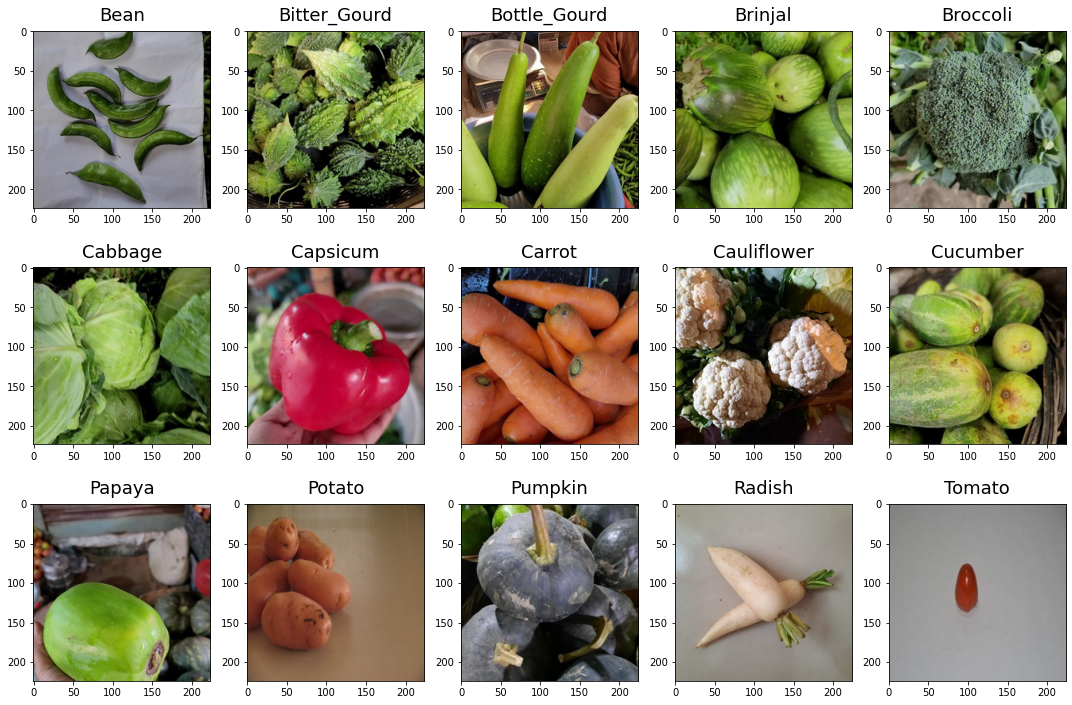

In [ ]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))

fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

In [ ]:
# Specify the desired image size for input to the model
IMAGE_SIZE = [224, 224]

# Load the InceptionV3 model with pre-trained weights from ImageNet, excluding the top layer
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the weights of all layers in the InceptionV3 model
for layer in inception.layers:
    layer.trainable = False

# Connect a custom top layer to the output of the InceptionV3 model
x = inception.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.2)(x)  # Dropout layer for regularization

# Output layer with softmax activation for multi-class classification (15 classes)
prediction = Dense(15, activation='softmax')(x)

# Create a new model with InceptionV3 as the base and the custom top layers
model = Model(inputs=inception.input, outputs=prediction)

# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Image data generator for augmenting training images
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,            # Rescale pixel values to the range [0,1]
    shear_range = 0.2,           # Apply shear transformation
    zoom_range = 0.2,            # Apply zoom transformation
    horizontal_flip = True       # Flip images horizontally
)

# Image data generator for normalizing test images (no augmentation)
test_datagen = image.ImageDataGenerator(
    rescale = 1./255              # Rescale pixel values to the range [0,1]
)

# Generate batches of augmented training data from the specified directory
training_set = train_datagen.flow_from_directory(
    train_folder,                 # Path to the training data directory
    target_size = (224, 224),      # Resize images to the specified dimensions
    batch_size = 64,               # Number of samples in each batch
    class_mode = 'categorical'     # Use categorical labels for multi-class classification
)

# Generate batches of normalized test data from the specified directory
test_set = test_datagen.flow_from_directory(
    test_folder,                  # Path to the test data directory
    target_size = (224, 224),      # Resize images to the specified dimensions
    batch_size = 64,               # Number of samples in each batch
    class_mode = 'categorical'     # Use categorical labels for multi-class classification
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
class_map = training_set.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [ ]:
# Train the model using the fit_generator method
r = model.fit_generator(
    training_set,                        # Training data generator
    validation_data=test_set,            # Validation data generator
    epochs=5,                            # Number of training epochs
    steps_per_epoch=len(training_set),    # Number of steps per epoch (number of batches in one epoch)
    validation_steps=len(test_set)        # Number of steps per validation epoch
)


Epoch 1/5
235/235 [==============================] - 268s 1s/step - loss: 0.2789 - accuracy: 0.9154 - val_loss: 0.0668 - val_accuracy: 0.9807
Epoch 2/5
235/235 [==============================] - 186s 793ms/step - loss: 0.0698 - accuracy: 0.9791 - val_loss: 0.0251 - val_accuracy: 0.9947
Epoch 3/5
235/235 [==============================] - 188s 798ms/step - loss: 0.0461 - accuracy: 0.9854 - val_loss: 0.0192 - val_accuracy: 0.9947
Epoch 4/5
235/235 [==============================] - 186s 791ms/step - loss: 0.0399 - accuracy: 0.9874 - val_loss: 0.0186 - val_accuracy: 0.9923
Epoch 5/5
235/235 [==============================] - 183s 777ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.0200 - val_accuracy: 0.9930


## Saving the Model

In [ ]:
model.save('model_inceptionV3_epoch5.h5')

## Accuracy and Loss Curves

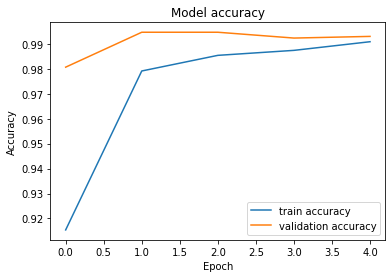

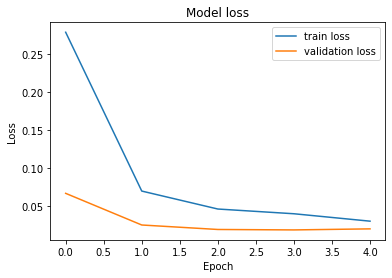

In [ ]:
def plot_accuracy(history):
    """
    Plot the training and validation accuracy over epochs.

    Parameters:
    - history: Training history obtained from model training

    Returns:
    - None
    """
    # Plot training accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')

    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'], label='validation accuracy')

    # Set plot title and labels
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Add legend for better interpretation
    plt.legend(loc='best')

    # Save the plot as an image file
    plt.savefig('Accuracy_v1_InceptionV3')

    # Display the plot
    plt.show()

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: Training history obtained from model training

    Returns:
    - None
    """
    # Plot training loss
    plt.plot(history.history['loss'], label="train loss")

    # Plot validation loss
    plt.plot(history.history['val_loss'], label="validation loss")

    # Set plot title and labels
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    # Add legend for better interpretation
    plt.legend(loc='best')

    # Save the plot as an image file
    plt.savefig('Loss_v1_InceptionV3')

    # Display the plot
    plt.show()

# Call the plotting functions with the training history
plot_accuracy(r)
plot_loss(r)


In [ ]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]:
    layer_names.append(layer.name)

print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])


Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


In [ ]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [ ]:
validation_data_dir = '../input/vegetable-image-dataset/Vegetable Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.992


<h2> Functions to predict the output of our model

In [ ]:
# Dictionary mapping category indices to corresponding vegetable names
category = {
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum',
    7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'
}

def predict_image(filename, model):
    """
    Predict the category of a single image and display the prediction along with the image.

    Parameters:
    - filename: Path to the image file
    - model: Trained model for image classification

    Returns:
    - None
    """
    # Load and preprocess the image
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    # Make the prediction using the model
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    # Display the prediction and the image
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir, model):
    """
    Evaluate the accuracy of the model on a directory of images and print the accuracy.

    Parameters:
    - filedir: Path to the directory containing images
    - model: Trained model for image classification

    Returns:
    - None
    """
    # Variables for organizing the subplot grid
    cols = 3
    pos = 0
    images = []
    total_images = len(os.listdir(filedir))
    rows = total_images // cols + 1

    # Extract true category from the directory name
    true = filedir.split('/')[-1]

    # Create a list of image paths in the directory
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir, i))

    # Loop through images, make predictions, and calculate accuracy
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        # Get the predicted category
        pred = category.get(index)

        # Check if the prediction matches the true category
        if pred == true:
            pos += 1

    # Calculate and print accuracy
    acc = pos / total_images
    print("Accuracy for {original}: {:.2f} ({pos}/{total})".format(acc, pos=pos, total=total_images, original=true))


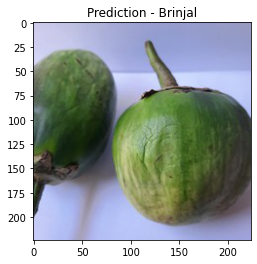

In [ ]:
predict_image(os.path.join(validation_folder,'Brinjal/1064.jpg'),model)

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for Broccoli: 0.99 (198/200)
Accuracy for Capsicum: 1.00 (200/200)
Accuracy for Bottle_Gourd: 0.99 (199/200)
Accuracy for Radish: 1.00 (200/200)
Accuracy for Tomato: 0.98 (197/200)
Accuracy for Brinjal: 0.99 (199/200)
Accuracy for Pumpkin: 1.00 (200/200)
Accuracy for Carrot: 1.00 (200/200)
Accuracy for Papaya: 0.95 (190/200)
Accuracy for Cabbage: 0.99 (199/200)
Accuracy for Bitter_Gourd: 0.99 (199/200)
Accuracy for Cauliflower: 0.99 (198/200)
Accuracy for Bean: 1.00 (200/200)
Accuracy for Cucumber: 0.99 (198/200)
Accuracy for Potato: 0.99 (198/200)


In [ ]:
def labels_confusion_matrix(validation_folder):
    """
    Generate true and predicted labels for images in the validation folder.

    Parameters:
    - validation_folder: Path to the validation folder containing subdirectories for each category.

    Returns:
    - Tuple of lists containing true and predicted labels.
    """
    folder_path = validation_folder

    # Create a mapping from category folder names to numerical labels
    mapping = {}
    for i, j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j] = i

    files = []
    real = []
    predicted = []

    # Iterate through the subdirectories in the validation folder
    for i in os.listdir(folder_path):
        true = os.path.join(folder_path, i)
        true_label = mapping[true.split('/')[-1]]

        # Iterate through images in each category subdirectory
        for j in os.listdir(os.path.join(folder_path, i)):
            img_ = image.load_img(os.path.join(folder_path, i, j), target_size=(224, 224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.

            # Make a prediction and record true and predicted labels
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)
            predicted.append(index)
            real.append(true_label)

    return (real, predicted)

def print_confusion_matrix(real, predicted):
    """
    Print a confusion matrix based on true and predicted labels.

    Parameters:
    - real: List of true labels
    - predicted: List of predicted labels

    Returns:
    - None
    """
    total_output_labels = 15
    cmap = "turbo"
    cm_plot_labels = [i for i in range(15)]

    # Generate confusion matrix using scikit-learn
    cm = confusion_matrix(y_true=real, y_pred=predicted)

    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)

    # Set up the seaborn heatmap for visualization
    sns.set(font_scale=1.2)  # Font size for labels
    plt.figure(figsize=(15, 10))
    s = sns.heatmap(df_cm, fmt="d", annot=True, cmap=cmap)

    # Set labels and save the plot as an image file
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

    # Display the plot
    plt.show()


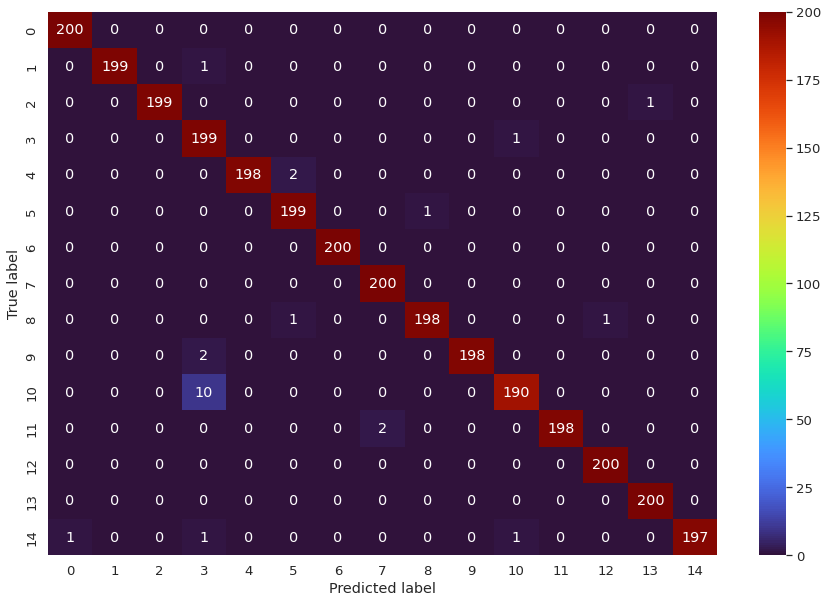

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

## Visualizing all incorrect images predicted for a particular vegetable category by our classifier.

In [ ]:
def wrong_input_capture(test_category):
    """
    Capture images in the test category that were incorrectly predicted by the model.

    Parameters:
    - test_category: Path to the test category folder.

    Returns:
    - List of tuples containing image paths and corresponding incorrect predictions.
    """
    # Extract the category name from the folder path
    true_category = os.path.basename(test_category)

    # List to store incorrectly predicted images and their predictions
    wrong_array = []

    # Loop through images in the test category
    for i in os.listdir(test_category):
        img_path = os.path.join(test_category, i)

        # Load and preprocess the image
        img_ = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.

        # Make a prediction using the model
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        pred = category.get(index)

        # Check if the prediction matches the true category
        if not pred == true_category:
            wrong_array.append((img_path, pred))

    return wrong_array

def visualize_wrong_input(images):
    """
    Visualize incorrectly predicted images and their predicted categories.

    Parameters:
    - images: List of tuples containing image paths and corresponding incorrect predictions.

    Returns:
    - None
    """
    # Set up the matplotlib figure for displaying images
    fig = plt.figure(1, figsize=(20, 25))
    total_images = len(images)
    rows = math.ceil(float(total_images / 3))

    # Loop through images and plot them along with predictions
    for subplot, (image_path, predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig = plt.subplot(rows, 3, subplot + 1)
        fig.set_title("Predicted - {}".format(predicted), pad=10, size=18)
        plt.imshow(img)

    # Adjust layout for better visualization
    plt.tight_layout()


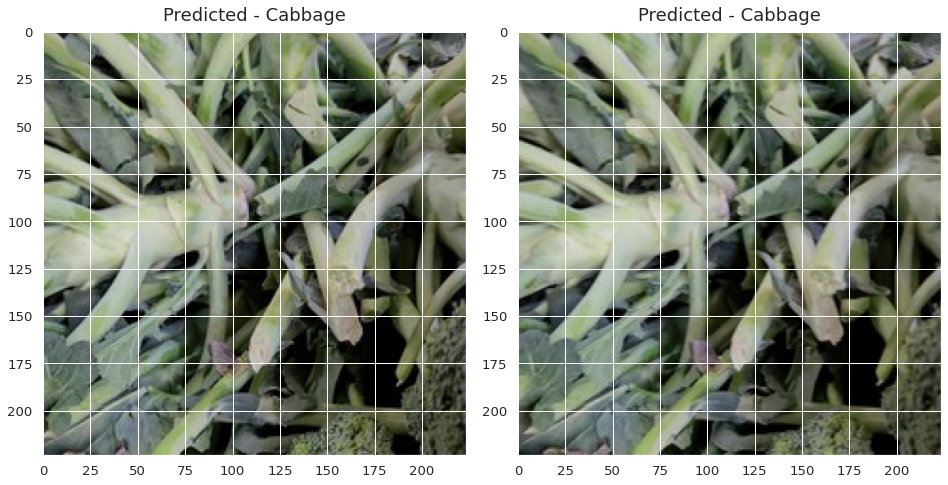

In [ ]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)

In [ ]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

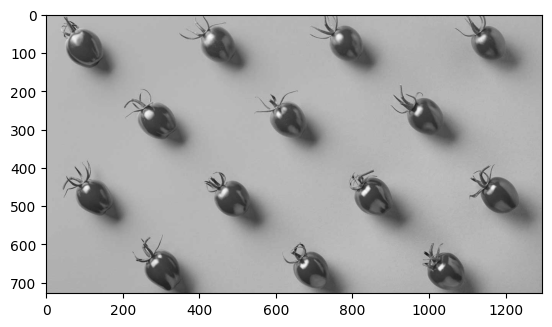

In [ ]:
image = cv2.imread('vegetable.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

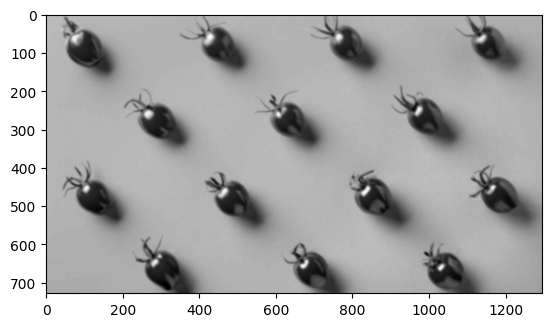

In [ ]:
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur, cmap='gray')

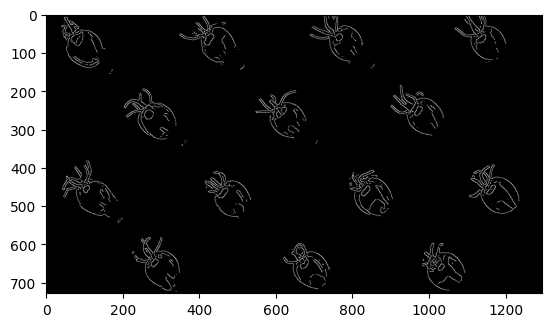

In [ ]:
canny = cv2.Canny(blur, 40, 40, 3)
plt.imshow(canny, cmap='gray')

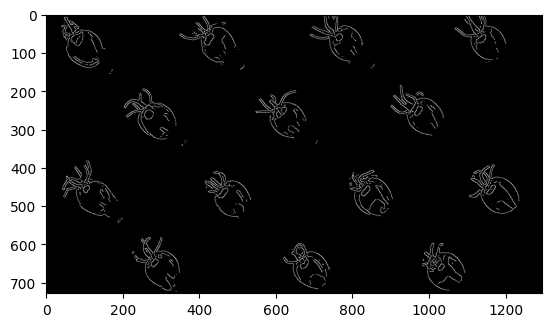

In [ ]:
dilated = cv2.dilate(canny, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')

In [ ]:
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)

array([[[146, 219, 138],
        [144, 217, 136],
        [142, 215, 134],
        ...,
        [120, 206, 117],
        [120, 206, 117],
        [120, 206, 117]],

       [[146, 219, 138],
        [144, 217, 136],
        [142, 215, 134],
        ...,
        [120, 206, 117],
        [120, 206, 117],
        [120, 206, 117]],

       [[146, 219, 138],
        [144, 217, 136],
        [142, 215, 134],
        ...,
        [120, 206, 117],
        [120, 206, 117],
        [120, 206, 117]],

       ...,

       [[123, 200, 118],
        [123, 200, 118],
        [123, 200, 118],
        ...,
        [102, 197, 105],
        [102, 197, 105],
        [102, 197, 105]],

       [[123, 200, 118],
        [123, 200, 118],
        [123, 200, 118],
        ...,
        [102, 197, 105],
        [102, 197, 105],
        [102, 197, 105]],

       [[123, 200, 118],
        [123, 200, 118],
        [123, 200, 118],
        ...,
        [102, 197, 105],
        [102, 197, 105],
        [102, 197, 105]]

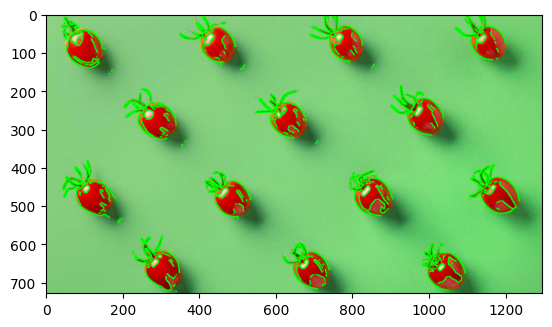

In [ ]:
plt.imshow(rgb)

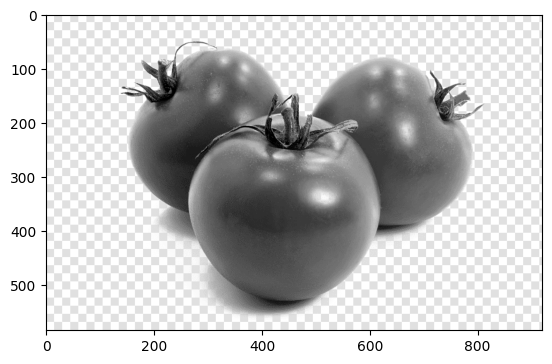

In [ ]:
image = cv2.imread('tomato.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

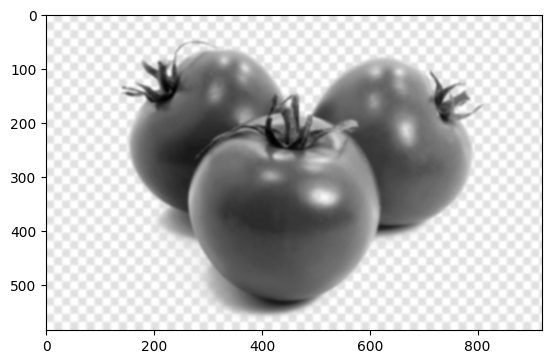

In [ ]:
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur, cmap='gray')

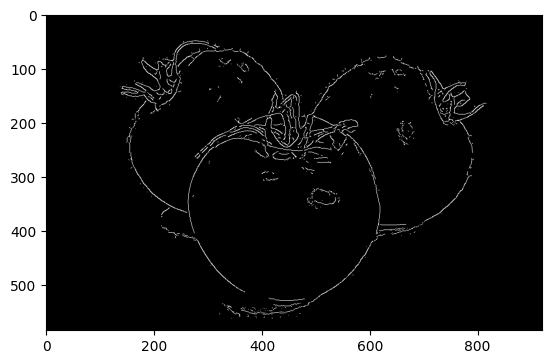

In [ ]:
canny = cv2.Canny(blur, 40, 40, 3)
plt.imshow(canny, cmap='gray')

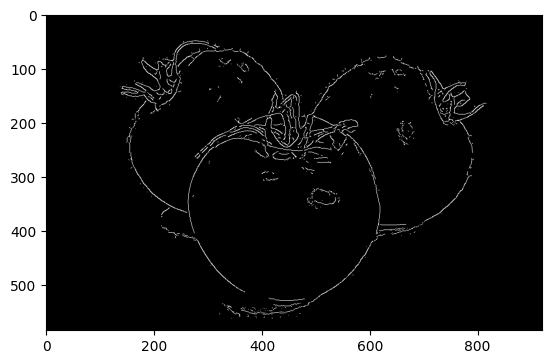

In [ ]:
dilated = cv2.dilate(canny, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')

In [ ]:
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [231, 230, 230],
        [231, 230, 230],
        [231, 230, 230]]

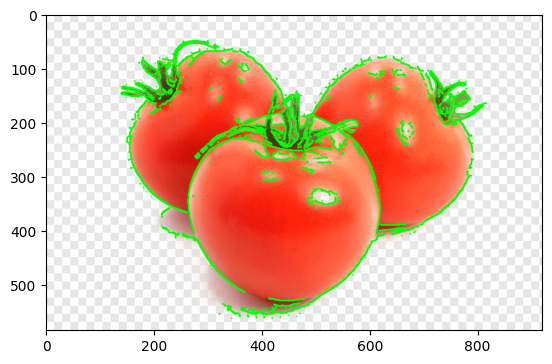

In [ ]:
plt.imshow(rgb)